In [157]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
wine = load_wine()
scaler = StandardScaler()
wine_std = scaler.fit_transform(wine.data)
df = pd.DataFrame(wine_std, columns=wine.feature_names)

In [159]:
from sklearn.decomposition import PCA
pca = PCA()
wine_pca = pca.fit_transform(wine_std)

### 차원 축소와 분류 정확도

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def pca_accuracy(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=2021
    )
    dtc = DecisionTreeClassifier(random_state=2021)
    dtc.fit(X_train, y_train)
    pred = dtc.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return np.round(acc, 4)

In [161]:
for dim in [2, 5, 10]:
    globals()[f'pca{dim}'] = PCA(n_components=dim)
    globals()[f'winePCA{dim}'] = globals()[f'pca{dim}'].fit_transform(wine_std)
    acc = pca_accuracy(globals()[f'winePCA{dim}'], wine.target)
    print(f'PCA {dim} 정확도: {acc}')
print('원데이터 정확도:', pca_accuracy(wine_std, wine.target))

PCA 2 정확도: 0.9074
PCA 5 정확도: 0.9444
PCA 10 정확도: 0.9444
원데이터 정확도: 0.8519


### 2차원 축소 데이터 시각화

In [162]:
wine_pca_df = pd.DataFrame(data=winePCA2, columns=['PC1','PC2'])
wine_pca_df['target'] = wine.target

In [163]:
wine.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

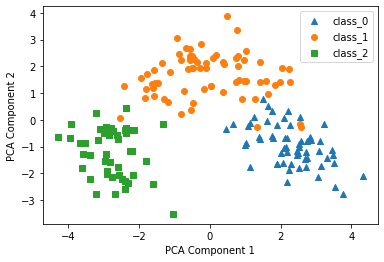

In [164]:
markers=['^', 'o','s']

# PC1 을 x축, PC2를 y축으로 scatter plot 수행. 
for i, marker in enumerate(markers):
    x_axis_data = wine_pca_df[wine_pca_df['target']==i]['PC1']
    y_axis_data = wine_pca_df[wine_pca_df['target']==i]['PC2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,
                label=wine.target_names[i])

plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## KMeans

In [165]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,random_state=2021)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2021, tol=0.0001, verbose=0)

In [166]:
df['target'] = wine.target    # 실제 target Class
df['cluster'] = kmeans.labels_  # Clustering 결과 도출된 Class  
df.sample(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,cluster
23,-0.186053,-0.660993,0.561033,-0.508966,-0.332922,0.296251,0.342082,-0.820719,-0.229346,-0.487978,0.581544,1.438311,0.853784,0,1
102,-0.816038,0.102021,0.341713,0.451946,-0.122282,0.424438,0.081051,-0.176095,-0.492158,-0.976782,-0.690784,1.085200,-0.983669,1,2
135,-0.494869,0.110998,-0.608676,-0.298767,-0.403135,-1.081754,-1.374701,2.160669,-1.140430,0.883269,-0.997898,-1.457197,-0.165254,2,0
61,-0.445459,-0.876432,-1.266637,-0.809251,0.018145,-0.440821,-0.621726,1.354888,-1.701097,0.299300,0.098937,-1.443072,-0.945455,1,0
91,-1.236028,-0.741782,0.195499,0.752231,-0.964842,-1.354150,-0.782361,1.113154,0.068508,-0.630726,0.406051,0.054117,-0.945455,1,2


In [167]:
wine.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [168]:
df['cluster'].unique(), df['target'].unique()

(array([1, 2, 0], dtype=int32), array([0, 1, 2]))

In [169]:
df['pca_x'] = wine_pca[:,0]
df['pca_y'] = wine_pca[:,1]
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,cluster,pca_x,pca_y
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,0,1,3.316751,-1.443463
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,0,1,2.209465,0.333393
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,0,1,2.516740,-1.031151
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,0,1,3.757066,-2.756372
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,0,1,1.008908,-0.869831


### 원본과 비교

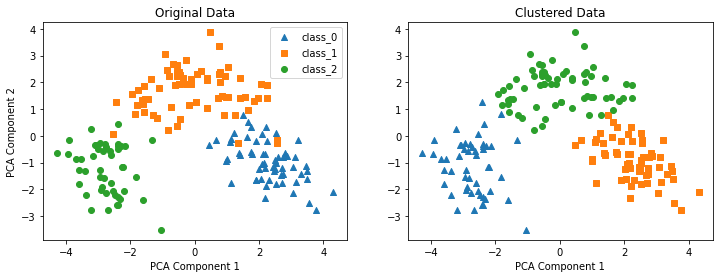

In [170]:
fig, axs = plt.subplots(figsize=(12,4),ncols=2,nrows=1)
columns = ['target','cluster']
markers = ['^',"s",'o']
for k, column in enumerate(columns):
    ax = axs[k]
    for i, marker in enumerate(markers):
        x_axis_data = df[df[column]==i]['pca_x']
        y_axis_data = df[df[column]==i]['pca_y']
        ax.scatter(x_axis_data, y_axis_data, marker=marker,label=wine.target_names[i])
    if k == 0:
        ax.set_title('Original Data')
        ax.set_ylabel('PCA Component 2')
        ax.legend()
    else:
        ax.set_title('Clustered Data')
    ax.set_xlabel('PCA Component 1')

### 실루엣 분석

In [171]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

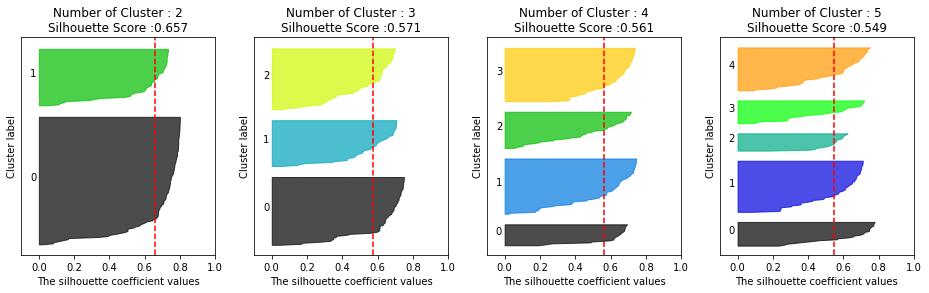

In [172]:
visualize_silhouette([ 2,3,4,5 ], wine.data)